In [2]:
from __future__ import division
from __future__ import print_function

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
import pickle

c:\Users\basma\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch Version:  1.12.1+cpu
Torchvision Version:  0.13.1+cpu


In [5]:
import os

# data_dir = '/content/gdrive/Shareddrives/Graduation Project (Kemet)/Datasets/SegmentedDataset'
data_dir = 'C:/Users/basma/Fourth Year/Graduation Project/Segmented Dataset'

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "squeezenet"

# Number of classes in the dataset
num_classes = 1072

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 40 

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [6]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import warnings

warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

labels_train = []
labels_val = []


def train_model(model, dataloaders, criterion, optimizer, num_epochs=15, is_inception=False):
    since = time.time()

    val_acc_history = []
    precicion_history = []
    recall_history = []
    f1_score_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_precision = 0.0
    best_recall = 0.0
    best_f1_score = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # if(phase=='train'):
                #   labels_train.append(labels)
                # else:
                #   labels_val.append(labels)

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # true_negative+= torch.sum(preds != labels.data)                          # preds => y_predict   labels.data => y_actual

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            precision = precision_score(labels.data, preds, average='macro')
            recall = recall_score(labels.data, preds, average='macro')
            score = f1_score(labels.data, preds, average='weighted')

            print('{} Loss: {:.4f} Acc: {:.4f} Precision: {:.4f} Recall: {:.4f} F1_score: {:.4f}'.format(phase,
                                                                                                            epoch_loss,
                                                                                                            epoch_acc,
                                                                                                            precision,
                                                                                                            recall,
                                                                                                            score))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'val' and precision > best_precision:
                best_precision = precision

            if phase == 'val' and recall > best_recall:
                best_recall = recall

            if phase == 'val' and score > best_f1_score:
                best_f1_score = score

            if phase == 'val':
                val_acc_history.append(epoch_acc)
                precicion_history.append(precision)
                recall_history.append(recall)
                f1_score_history.append(score)

        print()

    time_elapsed = time.time() - since
    print('Total time taken is {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Accuracy: {:3f}'.format(best_acc))
    print('Best val Precision: {:3f}'.format(best_precision))
    print('Best val Recall: {:3f}'.format(best_recall))
    print('Best val F1-Score: {:3f}'.format(best_f1_score))

    # confusion_matrix = metrics.confusion_matrix(labels.data, preds)
    # cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])
    # cm_display.plot()
    # plt.show()

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [7]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [8]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [9]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [10]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [11]:
print(image_datasets)
print(dataloaders_dict)

{'train': Dataset ImageFolder
    Number of datapoints: 32004
    Root location: C:/Users/basma/Fourth Year/Graduation Project/Segmented Dataset\train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 12751
    Root location: C:/Users/basma/Fourth Year/Graduation Project/Segmented Dataset\val
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}
{'train': <torch.utils.data.dataloader.DataLoader object at 0x000001FEFFE93E80>, 'val': <to

In [12]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [13]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))


Epoch 0/39
----------
train Loss: 5.9102 Acc: 0.0752 Precision: 0.0000 Recall: 0.0000 F1_score: 0.0000
val Loss: 3.9853 Acc: 0.2904 Precision: 0.2727 Recall: 0.2727 F1_score: 0.4286

Epoch 1/39
----------
train Loss: 4.0531 Acc: 0.2795 Precision: 0.1429 Recall: 0.1429 F1_score: 0.2500
val Loss: 2.4578 Acc: 0.5526 Precision: 0.5556 Recall: 0.5556 F1_score: 0.7143

Epoch 2/39
----------
train Loss: 3.2296 Acc: 0.4129 Precision: 0.1429 Recall: 0.1429 F1_score: 0.2500
val Loss: 1.7950 Acc: 0.6778 Precision: 0.5556 Recall: 0.5556 F1_score: 0.7143

Epoch 3/39
----------
train Loss: 2.8194 Acc: 0.4837 Precision: 0.6000 Recall: 0.6000 F1_score: 0.7500
val Loss: 1.4371 Acc: 0.7424 Precision: 0.7500 Recall: 0.7500 F1_score: 0.8571

Epoch 4/39
----------
train Loss: 2.5718 Acc: 0.5226 Precision: 0.6000 Recall: 0.6000 F1_score: 0.7500
val Loss: 1.2253 Acc: 0.7839 Precision: 0.7500 Recall: 0.7500 F1_score: 0.8571

Epoch 5/39
----------
train Loss: 2.4194 Acc: 0.5497 Precision: 0.1429 Recall: 0.1429

In [14]:
pickle.dump(model_ft, open('squeezenet(finetuned).pkl', 'wb'))

In [15]:
pickled_model = pickle.load(open('squeezenet(finetuned).pkl', 'rb'))

In [16]:
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(model_ft, hist)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

TypeError: Expected sequence or array-like, got <class 'torchvision.models.squeezenet.SqueezeNet'>

Epoch 0/39
----------
train Loss: 6.9674 Acc: 0.0007 Precision: 0.0000 Recall: 0.0000 F1_score: 0.0000
val Loss: 6.9107 Acc: 0.0009 Precision: 0.0000 Recall: 0.0000 F1_score: 0.0000

Epoch 1/39
----------
train Loss: 6.8671 Acc: 0.0013 Precision: 0.0000 Recall: 0.0000 F1_score: 0.0000
val Loss: 6.8257 Acc: 0.0017 Precision: 0.0000 Recall: 0.0000 F1_score: 0.0000

Epoch 2/39
----------
train Loss: 6.8025 Acc: 0.0022 Precision: 0.0000 Recall: 0.0000 F1_score: 0.0000
val Loss: 6.7467 Acc: 0.0031 Precision: 0.0000 Recall: 0.0000 F1_score: 0.0000

Epoch 3/39
----------
train Loss: 6.7500 Acc: 0.0038 Precision: 0.0000 Recall: 0.0000 F1_score: 0.0000
val Loss: 6.7025 Acc: 0.0048 Precision: 0.0000 Recall: 0.0000 F1_score: 0.0000

Epoch 4/39
----------
train Loss: 6.6918 Acc: 0.0048 Precision: 0.0000 Recall: 0.0000 F1_score: 0.0000
val Loss: 6.5997 Acc: 0.0069 Precision: 0.0000 Recall: 0.0000 F1_score: 0.0000

Epoch 5/39
----------
train Loss: 6.6465 Acc: 0.0056 Precision: 0.0000 Recall: 0.0000

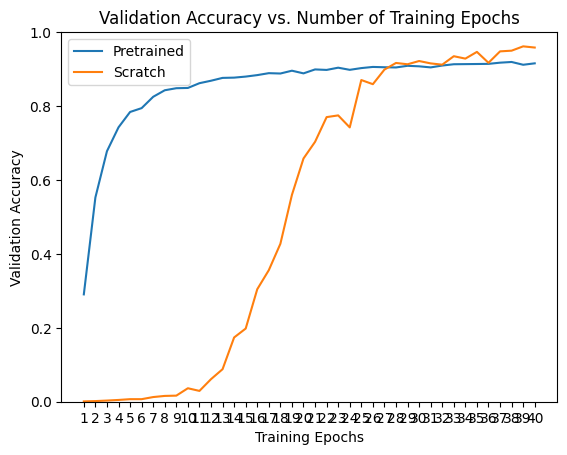

In [17]:
# Initialize the non-pretrained version of the model used for this run
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [18]:
pickle.dump(model_ft, open('squeezenet(untrained).pkl', 'wb'))

In [19]:
pickled_model = pickle.load(open('squeezenet(untrained).pkl', 'rb'))